In [ ]:
! pip install sqlalchemy pyodbc

In [2]:
import sqlalchemy
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest,RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap
from textwrap import wrap
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [3]:
server = r"SAKS\SQLEXPRESS"
database = "HEALTHCARE_"
username = "Saks"
password = "Sql@2025"

In [4]:
# Creating SQLAlchemy engine using PyODBC
engine = sqlalchemy.create_engine(f"mssql+pyodbc://{server}/{database}?driver=SQL+Server&trusted_connection=yes") 

In [ ]:
# Fetching all table names
query = "SELECT TABLE_NAME FROM INFORMATION_SCHEMA.TABLES WHERE TABLE_TYPE = 'BASE TABLE'"
df_tables = pd.read_sql(query, engine)

print(df_tables)

In [103]:
# Fetching data from a specific table
table_name = "Medicare_Charge_Inpatient"  
Medicare_Charge_Inpatient = pd.read_sql(f"SELECT * FROM {table_name}", engine)

table_name = "Medicare_Charge_Outpatient"  
Medicare_Charge_Outpatient = pd.read_sql(f"SELECT * FROM {table_name}", engine)

table_name = "Medicare_Provider_Charge_Inpatient"  
Medicare_Provider_Charge_Inpatient = pd.read_sql(f"SELECT * FROM {table_name}", engine)

table_name = "Medicare_Provider_Charge_Outpatient"  
Medicare_Provider_Charge_Outpatient = pd.read_sql(f"SELECT * FROM {table_name}", engine)

table_name = "Patient_history_samp"  
Patient_history_samp = pd.read_sql(f"SELECT * FROM {table_name}", engine)

table_name = "Review_patient_history_samp"  
Review_patient_history_samp = pd.read_sql(f"SELECT * FROM {table_name}", engine)

table_name = "Review_transaction_coo"  
Review_transaction_coo = pd.read_sql(f"SELECT * FROM {table_name}", engine)

table_name = "Transaction_coo"  
Transaction_coo = pd.read_sql(f"SELECT * FROM {table_name}", engine)

table_name = "DRGCodes_Global_proc_id_Mapping"  
Global_proc_id = pd.read_sql(f"SELECT * FROM {table_name}", engine)

In [319]:
Global_proc_id.columns

Index(['S_No', 'global_proc_id', 'DRG_Codes'], dtype='object')

In [7]:
Medicare_Provider_Charge_Inpatient.rename(columns={"Average_Total_Payments":"Average_Total_Payments_In","Provider_Name" : "Provider_Name_In","Provider_Street_Address":"Provider_Street_Address_In","Provider_City":"Provider_City_In","Provider_State":"Provider_State_In","Provider_Zip_Code":"Provider_Zip_Code_In","Hospital_Referral_Region_HRR_Description":"Hospital_Referral_Region_HRR_Description_In"},inplace=True)

Medicare_Provider_Charge_Outpatient.rename(columns={"Average_Total_Payments":"Average_Total_Payments_Out","Provider_Name" : "Provider_Name_Out","Provider_Street_Address":"Provider_Street_Address_Out","Provider_City":"Provider_City_Out","Provider_State":"Provider_State_Out","Provider_Zip_Code":"Provider_Zip_Code_Out","Hospital_Referral_Region_HRR_Description":"Hospital_Referral_Region_HRR_Description_Out"},inplace=True)

In [8]:
# Merge datasets on Provider_Id
merged_data = Medicare_Provider_Charge_Inpatient.merge(Medicare_Provider_Charge_Outpatient, on="Provider_Id")

In [ ]:
# display all the column
pd.set_option('display.max_columns', None)
merged_data.head(3)

Identify providers that overcharge for certain procedures or regions where procedures are too expensive.

Highest Cost Variation

Inpatient

In [ ]:
cost_variance_inpatient = Medicare_Provider_Charge_Inpatient.groupby("DRG_Definition", observed=True)["Average_Covered_Charges"].std().reset_index()
most_variable_procedure = cost_variance_inpatient.rename(columns={'Average_Covered_Charges':'Cost_variation'}).nlargest(5,"Cost_variation")

print("Most variable procedure Inpatient: \n")
most_variable_procedure

# answer : 870 - SEPTICEMIA OR SEVERE SEPSIS W MV 96+ HOURS has a std of 90,553.98, meaning that the total payments for this procedure vary, on average, by 90,553.98 from the mean payment for this procedure.

In [ ]:
# Visualization
plt.figure(figsize=(8, 4))
ax = sns.stripplot(
    x="Cost_variation", 
    y="DRG_Definition", 
    hue="DRG_Definition", 
    data=most_variable_procedure, 
    size=10, 
    palette="magma"
)

plt.xlabel("Standard Deviation of Covered Charges ($)", fontsize=12)
plt.ylabel("DRG Definition", fontsize=12)
plt.title("Top 5 Procedures with Highest Cost Variability (Inpatient)", fontsize=14)

# **Wrap Y-axis labels for readability**
wrapped_labels = [textwrap.fill(label, width=30) for label in most_variable_procedure["DRG_Definition"]]

# **Manually set wrapped labels by adjusting tick positions**
ax.set_yticks(range(len(wrapped_labels)))  # Set tick positions manually
ax.set_yticklabels(wrapped_labels)

plt.show()


Outpatient

In [ ]:
cost_variance_outpatient= Medicare_Provider_Charge_Outpatient.groupby("APC", observed=True)["Average_Estimated_Submitted_Charges"].std().reset_index()

most_variable_procedure_out = cost_variance_outpatient.rename(columns={'Average_Estimated_Submitted_Charges':'Cost_variation'}).nlargest(5,"Cost_variation")

print("Most variable procedure Outpatient: \n")
most_variable_procedure_out

In [ ]:
# Visualization
plt.figure(figsize=(8, 4))
ax = sns.stripplot(
    x="Cost_variation", 
    y="APC", 
    hue="APC", 
    data=most_variable_procedure_out, 
    size=10, 
    palette="magma"
)

plt.xlabel("Standard Deviation of Covered Charges ($)", fontsize=12)
plt.ylabel("DRG Definition", fontsize=12)
plt.title("Top 5 Procedures with Highest Cost Variability (Outpatient)", fontsize=14)

# **Wrap Y-axis labels for readability**
wrapped_labels = [textwrap.fill(label, width=30) for label in most_variable_procedure_out["APC"]]

# **Manually set wrapped labels by adjusting tick positions**
ax.set_yticks(range(len(wrapped_labels)))  # Set tick positions manually
ax.set_yticklabels(wrapped_labels)

plt.show()


Highest Cost claims by Provider

Inpatient

In [ ]:
# Finding the highest charge for a particular procedure 
procedure_high_cost = Medicare_Provider_Charge_Inpatient.groupby("DRG_Definition")['Average_Covered_Charges'].max().reset_index()
procedure_high_cost = procedure_high_cost.rename(columns={"Average_Covered_Charges":"Max_average_Covered_Charges"})

procedure_high_cost

In [ ]:
# merging the table to get the provider who charge the highest
Medicare_Inpatient_merge = Medicare_Provider_Charge_Inpatient.merge(procedure_high_cost,on="DRG_Definition",how = "left")
Medicare_Inpatient_merge


In [ ]:
# defining a function to flag the max_covered_charge
def flag(patient):
    if ((patient['Max_average_Covered_Charges']==patient['Average_Covered_Charges'])):
        return 1
    else:
        return 0
    
Medicare_Inpatient_merge['Flag_max'] = Medicare_Inpatient_merge.apply(flag,axis=1)
Medicare_Inpatient_merge[Medicare_Inpatient_merge['Flag_max']==1]

In [ ]:


# print the Highest cost claimed by provider 
Highest_cost_claim_by_provider  = Medicare_Inpatient_merge.loc[Medicare_Inpatient_merge['Flag_max']==1,["DRG_Definition",'Provider_Id',"Max_average_Covered_Charges"]]

print("Highest cost claimed by provider for a particular Inpatient procedure : \n")
Highest_cost_claim_by_provider

In [ ]:
# Visualization
# Ensure Provider_Id is a string
Highest_cost_claim_by_provider["Provider_Id"] = Highest_cost_claim_by_provider["Provider_Id"].astype(str)

# Select top 10 providers (remove duplicates if needed)
top_providers = (
    Highest_cost_claim_by_provider.sort_values(by="Max_average_Covered_Charges", ascending=False)
    .drop_duplicates(subset=["Provider_Id"])  # Ensure unique Provider IDs
    .head(10)
)

# Adjust figure size
fig, ax = plt.subplots(figsize=(14, 6), dpi=100)

# Create barplot with hue
sns.barplot(
    x="Max_average_Covered_Charges", 
    y="Provider_Id", 
    hue="Provider_Id", 
    data=top_providers, 
    palette="crest",
    errorbar=None,
    legend=False, 
    ax=ax
)

# Add data labels dynamically
for index, value in enumerate(top_providers["Max_average_Covered_Charges"]):
    text_x = value - 1500 
    text_align = 'right'
    
    # If bar is too short, move text outside
    if value < top_providers["Max_average_Covered_Charges"].max() * 0.15:
        text_x = value + 500  
        text_align = 'left'
    
    text_color = 'white' if text_align == 'right' else 'black'  # Ensure contrast

    ax.text(text_x,  
            index, 
            f'${value:,.0f}', 
            va='center', 
            ha=text_align, 
            fontsize=10, 
            color=text_color, 
            fontweight='bold')

# Labels and Title
plt.xlabel("Max_average_Covered_Charges ($)", fontsize=12)
plt.ylabel("Provider ID", fontsize=12)
plt.title("Top 10 Inpatient Providers with Highest Claimed Costs", fontsize=14)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Wrap long y-axis labels
wrapped_labels = ["\n".join(wrap(str(label), 10)) for label in top_providers["Provider_Id"]]
ax.set_yticks(range(len(wrapped_labels)))  
ax.set_yticklabels(wrapped_labels)  

# Adjust layout
plt.subplots_adjust(left=0.3, right=0.9, top=0.9, bottom=0.2)

plt.show()

Outpatient

In [ ]:
# Finding the highest charge for a particular procedure 
procedure_high_cost_out = Medicare_Provider_Charge_Outpatient.groupby("APC")['Average_Estimated_Submitted_Charges'].max().reset_index()
procedure_high_cost_out = procedure_high_cost_out.rename(columns={"Average_Estimated_Submitted_Charges":"Max_estimated_Charges"})

# merging the table to get the provider who charge the highest
Medicare_Outpatient_merge= Medicare_Provider_Charge_Outpatient.merge(procedure_high_cost_out,on="APC",how = "left")

# defining a function to flag the max_covered_charge
def flag_1(Medicare_Outpatient_merge):
    if ((Medicare_Outpatient_merge['Max_estimated_Charges']==Medicare_Outpatient_merge['Average_Estimated_Submitted_Charges'])):
        return 1
    else:
        return 0
    
Medicare_Outpatient_merge['Flag_max'] = Medicare_Outpatient_merge.apply(flag_1,axis=1)

# print the Highest cost claimed by provider 
Highest_cost_claim_by_provider_OUT  = Medicare_Outpatient_merge.loc[Medicare_Outpatient_merge['Flag_max']==1,["APC","Provider_Id","Max_estimated_Charges"]]

print("Highest cost claimed by provider for a particular Outpatient procedure : \n")
Highest_cost_claim_by_provider_OUT

In [ ]:
# Visualization
# Ensure Provider_Id is a string
Highest_cost_claim_by_provider_OUT["Provider_Id"] = Highest_cost_claim_by_provider_OUT["Provider_Id"].astype(str)

# Select top 10 providers (remove duplicates if needed)
top_providers = (
    Highest_cost_claim_by_provider_OUT.sort_values(by="Max_estimated_Charges", ascending=False)
    .drop_duplicates(subset=["Provider_Id"])  # Ensure unique Provider IDs
    .head(10)
)

# Adjust figure size
fig, ax = plt.subplots(figsize=(14, 6), dpi=100)

# Create barplot with hue
sns.barplot(
    x="Max_estimated_Charges", 
    y="Provider_Id", 
    hue="Provider_Id", 
    data=top_providers, 
    palette="magma",
    errorbar=None,
    legend=False, 
    ax=ax
)

# Add data labels dynamically
for index, value in enumerate(top_providers["Max_estimated_Charges"]):
    text_x = value - 1500 
    text_align = 'right'
    
    # If bar is too short, move text outside
    if value < top_providers["Max_estimated_Charges"].max() * 0.15:
        text_x = value + 500  
        text_align = 'left'
    
    text_color = 'white' if text_align == 'right' else 'black'  # Ensure contrast

    ax.text(text_x,  
            index, 
            f'${value:,.0f}', 
            va='center', 
            ha=text_align, 
            fontsize=10, 
            color=text_color, 
            fontweight='bold')

# Labels and Title
plt.xlabel("Max Estimated Charges ($)", fontsize=12)
plt.ylabel("Provider ID", fontsize=12)
plt.title("Top 10 Outpatient Providers with Highest Claimed Costs", fontsize=14)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Wrap long y-axis labels
wrapped_labels = ["\n".join(wrap(str(label), 10)) for label in top_providers["Provider_Id"]]
ax.set_yticks(range(len(wrapped_labels)))  
ax.set_yticklabels(wrapped_labels)  

# Adjust layout
plt.subplots_adjust(left=0.3, right=0.9, top=0.9, bottom=0.2)

plt.show()


 Highest Cost Calim by Region

Inpatient

In [ ]:
# print the Highest cost claimed by region 
Highest_cost_claim_by_region_in  = Medicare_Inpatient_merge.loc[Medicare_Inpatient_merge['Flag_max']==1,["DRG_Definition",'Hospital_Referral_Region_HRR_Description_In',"Max_average_Covered_Charges"]]

Highest_cost_claim_by_region_in['Procedure_&_Hospital_region'] = Highest_cost_claim_by_region_in['DRG_Definition']+" "+"@"+" " +Highest_cost_claim_by_region_in['Hospital_Referral_Region_HRR_Description_In']

print("Highest cost claimed by Region for a particular Inpatient Procedure : \n")
Highest_cost_claim_by_region_in

In [ ]:
# Sort and select top 10 regions
top_regions = Highest_cost_claim_by_region_in.sort_values(by="Max_average_Covered_Charges", ascending=False).head(10)

plt.figure(figsize=(12, 6))
ax  = sns.barplot(x="Max_average_Covered_Charges", 
            y="Procedure_&_Hospital_region", 
            data=top_regions, 
            hue="Procedure_&_Hospital_region", 
            palette="viridis",
            legend=False,
            errorbar=None) 

# Add data labels
for index, value in enumerate(top_regions["Max_average_Covered_Charges"]):
    ax.text(value - 1000, index, f'${value:,.0f}', va='center', ha='right', fontsize=10, color='white', fontweight='bold')

plt.xlabel("Max Estimated Charges ($)")
plt.ylabel("Procedure_&_Hospital_region")
plt.title("Top 10 Inpatient Regions with Highest Claimed Costs")
plt.show()


Outpatient

In [ ]:
# print the Highest cost claimed by region 
Highest_cost_claim_by_region  = Medicare_Outpatient_merge.loc[Medicare_Outpatient_merge['Flag_max']==1,["APC",'Hospital_Referral_Region_HRR_Description_Out',"Max_estimated_Charges"]]

Highest_cost_claim_by_region['Procedure_&_Hospital_region'] = Highest_cost_claim_by_region['APC']+" "+"@"+" " +Highest_cost_claim_by_region['Hospital_Referral_Region_HRR_Description_Out']

print("Highest cost claimed by Region for a particular Outpatient Procedure : \n")
Highest_cost_claim_by_region

In [ ]:
# Sort and select top 10 regions
top_regions = Highest_cost_claim_by_region.sort_values(by="Max_estimated_Charges", ascending=False).head(10)

plt.figure(figsize=(12, 6))
ax  = sns.barplot(x="Max_estimated_Charges", 
            y="Procedure_&_Hospital_region", 
            data=top_regions, 
            hue="Procedure_&_Hospital_region", 
            palette="viridis",
            legend=False,
            errorbar=None) 

# Add data labels
for index, value in enumerate(top_regions["Max_estimated_Charges"]):
    ax.text(value - 1000, index, f'${value:,.0f}', va='center', ha='right', fontsize=10, color='white', fontweight='bold')

plt.xlabel("Max Estimated Charges ($)")
plt.ylabel("Procedure_&_Hospital_region")
plt.title("Top 10 Outpatient Regions with Highest Claimed Costs")
plt.show()


Highest Number of Procedures and Largest Differences between Claims and Reimbursements


Inpatient

In [ ]:
# Calculate claim difference
Medicare_Provider_Charge_Inpatient["claim_differnce"] = Medicare_Provider_Charge_Inpatient["Average_Covered_Charges"] - Medicare_Provider_Charge_Inpatient["Average_Total_Payments_In"]

# Procedure occurnace count
procedure_counts = Medicare_Provider_Charge_Inpatient["DRG_Definition"].value_counts().reset_index()
procedure_counts.columns = ["DRG_Definition", "procedure_count"]

# Find the max claim difference for each procedure
max_claims = Medicare_Provider_Charge_Inpatient.groupby("DRG_Definition")["claim_differnce"].max().reset_index()
max_claims.rename(columns={"claim_differnce": "Max_claim_differnce"}, inplace=True)

# Merge both datasets
final_df_in = procedure_counts.merge(max_claims, on="DRG_Definition", how="left")

# Rank based on both criteria
final_df_in["Rank"] = final_df_in["procedure_count"] * final_df_in["Max_claim_differnce"]


final_df_in.sort_values(by="Rank",ascending=False)

# explanation - First procedure is performed 1163 times accros all the providers and have the max claim difference of 79891.18 and accordingly it is ranks the highest because it's Frequency rate and max_claim_difference is high


In [ ]:
# Visualization
# Select Top 5 Procedures and Sort in Descending Order
top_5 = final_df_in.nlargest(5, "Rank").sort_values(by="Rank", ascending=False)

# Function to wrap text
def wrap_labels(labels, width=40):
    return ['\n'.join(textwrap.wrap(label, width)) for label in labels]

# Apply Wrapping to DRG_Definition Names
top_5["DRG_Definition"] = wrap_labels(top_5["DRG_Definition"])

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x="Max_claim_differnce", y="DRG_Definition", data=top_5, hue="procedure_count", palette="viridis")

# Labels and Title
plt.xlabel("Max Claim Difference ($)", fontsize=12)
plt.ylabel("Procedure (DRG_Definition)", fontsize=12)
plt.title("Top 5 Inpatient Procedures with Highest Claim Differences (Descending Order)", fontsize=14)
plt.legend(title="Procedure Count")

# Adjust Layout to Fit Text
plt.tight_layout()

# Display
plt.show()


Outpatient

In [ ]:
#  Calculate claim difference
Medicare_Provider_Charge_Outpatient["claim_differnce"] = Medicare_Provider_Charge_Outpatient["Average_Estimated_Submitted_Charges"] - Medicare_Provider_Charge_Outpatient["Average_Total_Payments_Out"]
Medicare_Provider_Charge_Outpatient.head(1)

# Procedure occurance count
procedure_counts = Medicare_Provider_Charge_Outpatient["APC"].value_counts().reset_index()
procedure_counts.columns = ["APC", "procedure_count"]

# Find the max claim difference for each procedure
max_claims = Medicare_Provider_Charge_Outpatient.groupby("APC")["claim_differnce"].max().reset_index()
max_claims.rename(columns={"claim_differnce": "Max_claim_differnce"}, inplace=True)
max_claims

# Merge both datasets
final_df_out = procedure_counts.merge(max_claims, on="APC", how="left")

# Rank based on both criteria
final_df_out["Rank"] = final_df_out["procedure_count"] * final_df_out["Max_claim_differnce"]

final_df_out.sort_values(by="Rank",ascending=False).head(5)

In [ ]:
# Visualization
# Select Top 5 Procedures and Sort in Descending Order
top_5 = final_df_out.nlargest(5, "Rank").sort_values(by="Rank", ascending=False)

# Function to wrap text
def wrap_labels(labels, width=40):
    return ['\n'.join(textwrap.wrap(label, width)) for label in labels]

# Apply Wrapping to APC Names
top_5["APC"] = wrap_labels(top_5["APC"])

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x="Max_claim_differnce", y="APC", data=top_5, hue="procedure_count", palette="viridis")

# Labels and Title
plt.xlabel("Max Claim Difference ($)", fontsize=12)
plt.ylabel("Procedure (APC)", fontsize=12)
plt.title("Top 5 Outpatient Procedures with Highest Claim Differences (Descending Order)", fontsize=14)
plt.legend(title="Procedure Count")

# Adjust Layout to Fit Text
plt.tight_layout()

# Display
plt.show()


# Part 2

Finding 3 Providers least like others

In [29]:
# Select numerical features
features = ["Outpatient_Services", "Average_Estimated_Submitted_Charges", "Average_Total_Payments_Out","Average_Total_Payments_In","Total_Discharges", "Average_Covered_Charges", "Average_Medicare_Payments"]

In [ ]:
data = merged_data[["Provider_Id"] + features]
data.head(5)

In [ ]:
# check for null values
data.isna().sum()

In [32]:
# Normalize data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[features])

In [33]:
# Apply Isolation Forest for anomaly detection
iso_forest = IsolationForest(contamination=0.01, random_state=42)
anomaly_scores = iso_forest.fit_predict(data_scaled)

In [ ]:
# Identify least similar providers (anomalies)
data = data.copy()
data.loc[:,"Anomaly_Score"] = anomaly_scores
least_similar_providers = data[data["Anomaly_Score"] == -1].head(3)
print("Least Similar Providers:")
print(least_similar_providers[["Provider_Id"]])

 Finding the 3 regions least like others


In [35]:
# Define Features for Each Category
inpatient_features = ["Total_Discharges", "Average_Covered_Charges", "Average_Total_Payments_In", "Average_Medicare_Payments"]

outpatient_features = ["Outpatient_Services", "Average_Estimated_Submitted_Charges", "Average_Total_Payments_Out"]


In [36]:
# Aggregate Data by Region
df_inpatient_region = Medicare_Provider_Charge_Inpatient.groupby("Hospital_Referral_Region_HRR_Description_In")[inpatient_features].mean().reset_index()

df_outpatient_region = Medicare_Provider_Charge_Outpatient.groupby("Hospital_Referral_Region_HRR_Description_Out")[outpatient_features].mean().reset_index()

In [37]:
# Normalize Data
scaler = StandardScaler()
df_inpatient_scaled = scaler.fit_transform(df_inpatient_region[inpatient_features]) #Normalizing the numerical values
df_outpatient_scaled = scaler.fit_transform(df_outpatient_region[outpatient_features]) 

In [38]:
# Apply Isolation Forest for Inpatient
iso_forest_inpatient = IsolationForest(contamination=0.01, random_state=42)
df_inpatient_region["Anomaly_Score"] = iso_forest_inpatient.fit_predict(df_inpatient_scaled)

# Apply Isolation Forest for Outpatient
iso_forest_outpatient = IsolationForest(contamination=0.01, random_state=42)
df_outpatient_region["Anomaly_Score"] = iso_forest_outpatient.fit_predict(df_outpatient_scaled)

In [ ]:
# Get the Three Least Similar Regions for Inpatient
least_similar_inpatient_regions = df_inpatient_region[df_inpatient_region["Anomaly_Score"] == -1].nsmallest(3, "Anomaly_Score")

# Get the Three Least Similar Regions for Outpatient
least_similar_outpatient_regions = df_outpatient_region[df_outpatient_region["Anomaly_Score"] == -1].nsmallest(3, "Anomaly_Score")

print("Three Regions Least Like Others (Inpatient):")
print(least_similar_inpatient_regions[["Hospital_Referral_Region_HRR_Description_In"]])
print("------------------------------------------------------")
print("Three Regions Least Like Others (Outpatient):")
print(least_similar_outpatient_regions[["Hospital_Referral_Region_HRR_Description_Out"]])

In [40]:
#-------------------------------------------------------------------------------------

In [ ]:
Medicare_Provider_Charge_Inpatient.columns

# least 3 provider ( second method ) 

find meaning for this part 

In [ ]:
Medicare_Provider_Charge_Inpatient.columns

In [43]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


# Select numerical features
numerical_cols = [
    "Total_Discharges", "Average_Covered_Charges", "Average_Total_Payments_In",
    "Average_Medicare_Payments", "claim_differnce"
]

df_selected = Medicare_Provider_Charge_Inpatient[numerical_cols]


# Fill missing values with median (robust against outliers)
df_selected = df_selected.fillna(df_selected.median())

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_selected)


In [ ]:
pca = PCA(n_components=3)  # Reduce to 3 dimensions
X_pca = pca.fit_transform(X_scaled)

print(f"Explained Variance Ratio: {pca.explained_variance_ratio_}")

In [ ]:
kmeans = KMeans(n_clusters=5, random_state=42)
Medicare_Provider_Charge_Inpatient["Cluster"] = kmeans.fit_predict(X_pca)

# Compute distance from cluster centers
distances = kmeans.transform(X_pca).min(axis=1)
Medicare_Provider_Charge_Inpatient["DistanceToCenter"] = distances

# Select 3 least similar providers
least_similar_providers = Medicare_Provider_Charge_Inpatient.nlargest(3, "DistanceToCenter")

print("Least Similar Providers:")
print(least_similar_providers[["Provider_Name_In", "DistanceToCenter"]])


# Region

In [46]:
df_regions = Medicare_Provider_Charge_Inpatient.groupby("Hospital_Referral_Region_HRR_Description_In")[numerical_cols].mean().reset_index()

# Standardize the regional data
X_regions_scaled = scaler.fit_transform(df_regions[numerical_cols])
X_regions_pca = pca.fit_transform(X_regions_scaled)


In [47]:
import os
os.environ["OMP_NUM_THREADS"] = "2"

In [ ]:
kmeans = KMeans(n_clusters=5, random_state=42)
df_regions["Cluster"] = kmeans.fit_predict(X_regions_pca)

# Compute distance from cluster centers
distances = kmeans.transform(X_regions_pca).min(axis=1)
df_regions["DistanceToCenter"] = distances

# Select 3 least similar regions
least_similar_regions = df_regions.nlargest(3, "DistanceToCenter")

print("Least Similar Regions:")
print(least_similar_regions[["Hospital_Referral_Region_HRR_Description_In", "DistanceToCenter"]])

# The least similar regions are those with the highest DistanceToCenter, meaning they are farthest from their assigned cluster center.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

df_regions["Cluster"] = kmeans.labels_

# Boxplot to compare a key feature across clusters
plt.figure(figsize=(12,6))
sns.boxplot(x="Cluster", y="Average_Covered_Charges", data=df_regions)
plt.title("Distribution of Covered Charges by Cluster")
plt.show()


# PART 3

Identify 10,000 Medicare patients who are involved in anomalous activities. 

In [ ]:
Patient_history_samp.head(2)

In [ ]:
Transaction_coo.head(2)

In [ ]:
Global_proc_id.head(2)

In [ ]:
Medicare_Charge_Inpatient.head(1)

In [212]:
Medicare_Charge_Inpatient[['DRG_Codes', 'DRG_Description']] = Medicare_Charge_Inpatient['DRG_Definition'].str.split(' - ', n=1, expand=True)
Medicare_Charge_Inpatient['DRG_Codes'] = Medicare_Charge_Inpatient['DRG_Codes'].astype(int)
Medicare_Charge_Inpatient.head(2)

,DRG_Definition,Total_Discharges,Average_Covered_Charges,Average_Total_Payments,Average_Medicare_Payments,DRG_Codes,DRG_Description
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,37861,29228.552734,6902.381348,5514.436035,39,EXTRACRANIAL PROCEDURES W/O CC/MCC
1,057 - DEGENERATIVE NERVOUS SYSTEM DISORDERS W/...,37927,23924.980469,6809.799316,5791.920410,57,DEGENERATIVE NERVOUS SYSTEM DISORDERS W/O MCC


In [213]:
# Merging patient table and transaction table

merge_table= pd.merge(Patient_history_samp,Transaction_coo,on='id',how="inner")

In [214]:
# merging these table with the global proc table

merge_table2 = pd.merge(merge_table,Global_proc_id,on='global_proc_id',how='inner')

In [215]:
# merging with medicare_charge_inpatient table

df = pd.merge(merge_table2,Medicare_Charge_Inpatient,on="DRG_Codes",how='inner')

In [216]:
df.drop(columns={"count","S_No","DRG_Definition"},inplace = True)

In [228]:
age_mapping = {'<65': 1, '65-74': 2, '75-84': 3, '85+': 4}
income_mapping = {'<16000 ': 1, '16000-23999': 2, '24000-31999': 3, '32000-47999': 4,'48000+':5}
gender_mapping = {'F':1,",M":2}

In [231]:
df['Age_Group'] = df['age'].map(age_mapping)
df['Income_Level'] = df['income'].map(income_mapping).fillna(1).astype(int)
df['Gender_group'] = df['gender'].map(gender_mapping).fillna(1).astype(int)

In [232]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1047605 entries, 0 to 1047604
Data columns (total 15 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   id                         1047605 non-null  int64  
 1   age                        1047605 non-null  object 
 2   gender                     1047605 non-null  object 
 3   income                     1047605 non-null  object 
 4   global_proc_id             1047605 non-null  int64  
 5   DRG_Codes                  1047605 non-null  int64  
 6   Total_Discharges           1047605 non-null  int64  
 7   Average_Covered_Charges    1047605 non-null  float64
 8   Average_Total_Payments     1047605 non-null  float64
 9   Average_Medicare_Payments  1047605 non-null  float64
 10  DRG_Description            1047605 non-null  object 
 11  Age_Group                  1047605 non-null  int64  
 12  Income_Level               1047605 non-null  int32  
 13  Anomaly_Scor

In [233]:
df.head(1)

,id,age,gender,income,global_proc_id,DRG_Codes,Total_Discharges,Average_Covered_Charges,Average_Total_Payments,Average_Medicare_Payments,DRG_Description,Age_Group,Income_Level,Anomaly_Score,Gender_group
0,306535165,65-74,F,24000-31999,25,243,35115,67032.054688,18158.527344,16775.830078,PERMANENT CARDIAC PACEMAKER IMPLANT W CC,2,3,1,1


In [263]:
# Selecting the features to perform anomaly detection
health_feature = ["Age_Group","Income_Level","Gender_group","DRG_Codes","Total_Discharges","Average_Covered_Charges","Average_Total_Payments","Average_Medicare_Payments"]


# Apply Isolation Forest for anomaly detection
iso_forest = IsolationForest(contamination="auto", random_state=42)  # 1% anomalies
df['Anomaly_Score'] = iso_forest.fit_predict(df[health_feature])

# 1 is non-anomalous
# -1 is anomalous

In [264]:
Anomalous_Patients = df[df["Anomaly_Score"]==-1].nsmallest(10000,'Anomaly_Score')
Anomalous_Patients

,id,age,gender,income,global_proc_id,DRG_Codes,Total_Discharges,Average_Covered_Charges,Average_Total_Payments,Average_Medicare_Payments,DRG_Description,Age_Group,Income_Level,Anomaly_Score,Gender_group
5,83686538,<65,F,32000-47999,2,57,37927,23924.980469,6809.799316,5791.920410,DEGENERATIVE NERVOUS SYSTEM DISORDERS W/O MCC,1,4,-1,1
9,247750664,75-84,F,<16000,22,207,33407,139651.562500,38473.890625,35916.062500,RESPIRATORY SYSTEM DIAGNOSIS W VENTILATOR SUPP...,3,1,-1,1
12,141100339,<65,M,32000-47999,17,193,131396,37408.980469,9997.520508,8952.174805,SIMPLE PNEUMONIA & PLEURISY W MCC,1,4,-1,1
20,769089007,75-84,M,32000-47999,1,39,37861,29228.552734,6902.381348,5514.436035,EXTRACRANIAL PROCEDURES W/O CC/MCC,3,4,-1,1
24,965505524,75-84,F,<16000,17,193,131396,37408.980469,9997.520508,8952.174805,SIMPLE PNEUMONIA & PLEURISY W MCC,3,1,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21353,635255801,85+,F,16000-23999,17,193,131396,37408.980469,9997.520508,8952.174805,SIMPLE PNEUMONIA & PLEURISY W MCC,4,2,-1,1
21356,579948391,65-74,F,16000-23999,19,195,83703,18004.697266,4850.171875,3733.150879,SIMPLE PNEUMONIA & PLEURISY W/O CC/MCC,2,2,-1,1
21359,537575236,65-74,F,32000-47999,28,247,109584,62020.847656,14300.149414,11823.961914,PERC CARDIOVASC PROC W DRUG-ELUTING STENT W/O MCC,2,4,-1,1
21361,944584586,65-74,F,<16000,27,246,30459,93338.718750,23276.484375,21021.707031,PERC CARDIOVASC PROC W DRUG-ELUTING STENT W MC...,2,1,-1,1


In [266]:
# ---------------------------visual for ppt=------------------------------

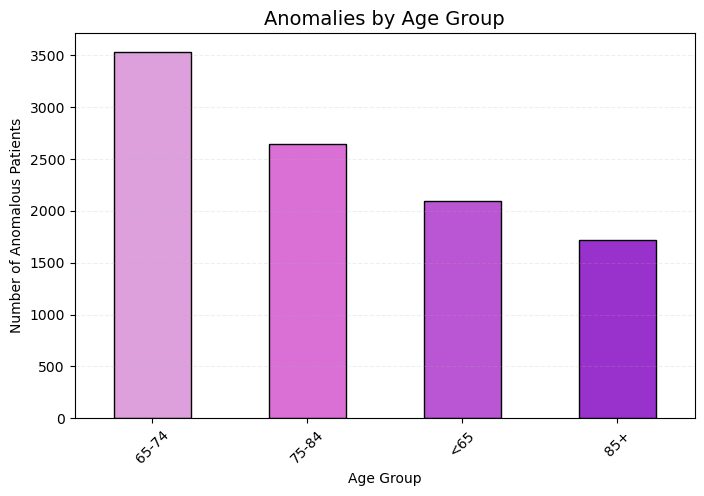

In [289]:
# Bar Chart - Anomalies by Age Group

# Filter anomalies
age_group_counts = Anomalous_Patients['age'].value_counts()

# Define colors for bars
colors = ["plum", "orchid", "mediumorchid", "darkorchid", "purple"]

plt.figure(figsize=(8, 5))  # Slightly larger for better visibility
age_group_counts.plot(kind='bar', color=colors, edgecolor='black')

plt.title("Anomalies by Age Group", fontsize=14)
plt.xlabel("Age Group", fontsize=10)
plt.ylabel("Number of Anomalous Patients", fontsize=10)
plt.xticks(rotation=45, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.2)  # Light grid for clarity

plt.show()


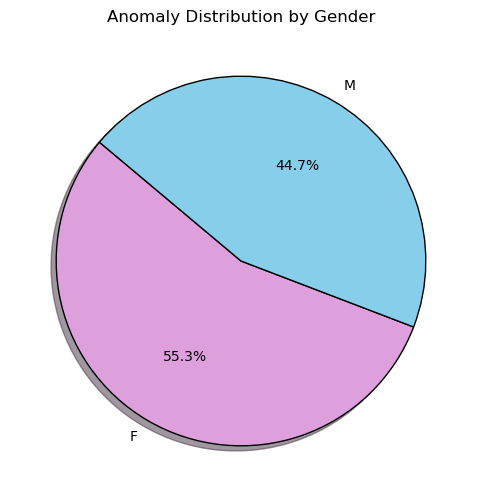

In [292]:
# Count anomalies by gender
gender_counts = Anomalous_Patients['gender'].value_counts()

# Define colors
colors = ["plum", "skyblue"]  # Adjust as needed for better contrast

plt.figure(figsize=(6, 6))
plt.pie(gender_counts, 
        labels=gender_counts.index, 
        autopct='%1.1f%%', 
        startangle=140, 
        colors=colors, 
        shadow=True, 
        wedgeprops={'edgecolor': 'black'})  # Adds black edge for clarity

plt.title("Anomaly Distribution by Gender")
plt.show()


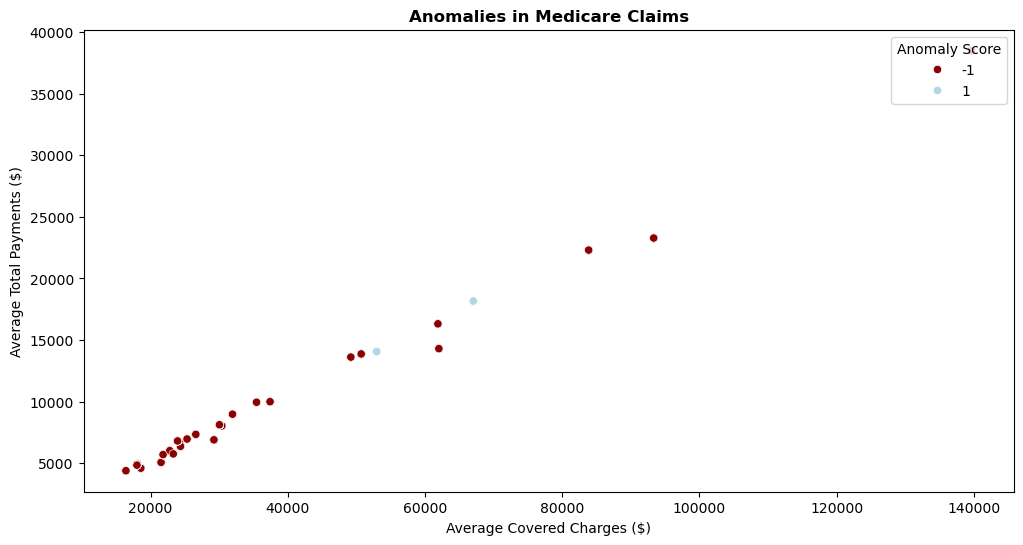

In [312]:
plt.figure(figsize=(12, 6))
sns.scatterplot(
    x=df['Average_Covered_Charges'], 
    y=df['Average_Total_Payments'], 
    hue=df['Anomaly_Score'], 
    palette={1: "lightblue", -1: "darkred"}
)
plt.title("Anomalies in Medicare Claims", fontweight='bold')
plt.xlabel("Average Covered Charges ($)")
plt.ylabel("Average Total Payments ($)")
plt.legend(title="Anomaly Score", loc="upper right")  
plt.show()


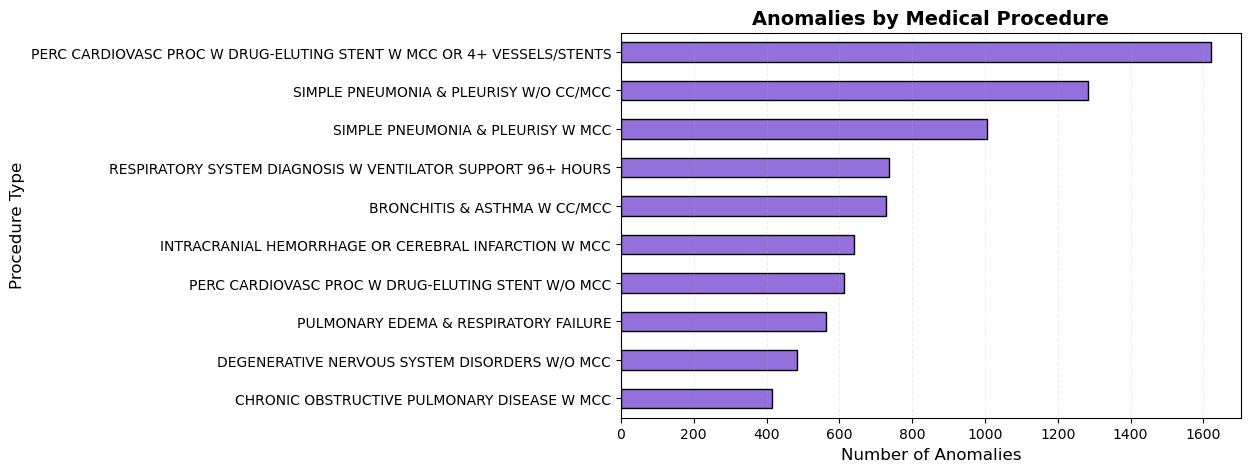

In [303]:
# Bar Chart - Anomalies by Procedure

# Filter anomalies
procedure_counts = Anomalous_Patients['DRG_Description'].value_counts().head(10)  # Top 10 procedures

plt.figure(figsize=(8, 5))
procedure_counts.plot(kind='barh', color = "mediumpurple", edgecolor='black')  # Change color here

plt.title("Anomalies by Medical Procedure", fontsize=14, fontweight='bold')
plt.xlabel("Number of Anomalies", fontsize=12)
plt.ylabel("Procedure Type", fontsize=12)
plt.gca().invert_yaxis()  # Flip chart for better readability
plt.grid(axis='x', linestyle='--', alpha=0.2)

plt.show()


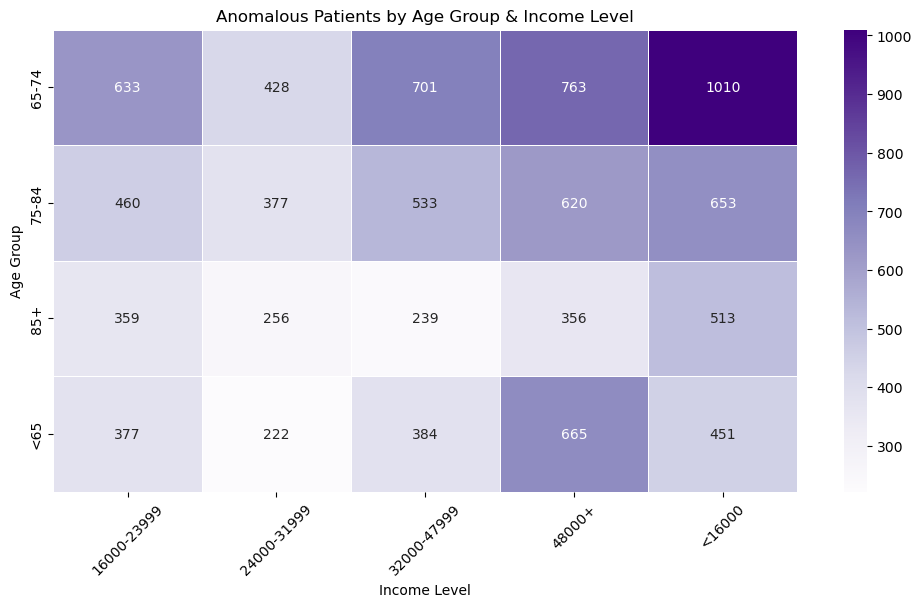

In [311]:
# Income Level vs Age Group for Anomalies
plt.figure(figsize=(12, 6))
# Pivot table for heatmap
heatmap_data = Anomalous_Patients.pivot_table(index="age", columns="income", aggfunc="size", fill_value=0)
sns.heatmap(heatmap_data, cmap="Purples", annot=True, fmt="d", linewidths=0.5, cbar=True)
plt.xlabel("Income Level")
plt.ylabel("Age Group")
plt.title("Anomalous Patients by Age Group & Income Level")
plt.xticks(rotation=45)
plt.show()

In [320]:
Medicare_Provider_Charge_Inpatient.head(1)

,DRG_Definition,Provider_Id,Provider_Name,Provider_Street_Address,Provider_City,Provider_State,Provider_Zip_Code,Hospital_Referral_Region_HRR_Description,Total_Discharges,Average_Covered_Charges,Average_Total_Payments,Average_Medicare_Payments
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91,32963.078125,5777.241699,4763.736328


In [321]:
Medicare_Provider_Charge_Outpatient.head(1)

,APC,Provider_Id,Provider_Name,Provider_Street_Address,Provider_City,Provider_State,Provider_Zip_Code,Hospital_Referral_Region_HRR_Description,Outpatient_Services,Average_Estimated_Submitted_Charges,Average_Total_Payments
0,0012 - Level I Debridement & Destruction,10029,EAST ALABAMA MEDICAL CENTER AND SNF,2000 PEPPERELL PARKWAY,OPELIKA,AL,36801,AL - Birmingham,23,78.08696,21.910435


### **🔍 Predictive Analytics Problem Statements (Healthcare & Medicare Fraud)**
Since you are working with **Medicare payment data**, you can explore several predictive analytics problems. Here are some problem statements:

---

### **1️⃣ Fraud Detection in Medicare Claims**  
**Problem Statement:**  
Predict whether a **Medicare claim** is fraudulent based on billing patterns, claim amounts, and provider history.  
**Model:** Classification (Logistic Regression, Random Forest, XGBoost, Isolation Forest for anomalies)  
**Dataset Features:**  
- Provider ID  
- Procedure Type  
- Total Charges vs. Medicare Payments  
- Frequency of Claims by Provider  
- Outlier Detection in Billing  

---

### **2️⃣ Predicting Overpriced Procedures**  
**Problem Statement:**  
Predict if a hospital **overcharges for a procedure** compared to industry standards.  
**Model:** Regression (Linear Regression, XGBoost, Random Forest)  
**Dataset Features:**  
- **Average Covered Charges** (Cost to patient)  
- **Average Medicare Payments** (Actual reimbursement)  
- **Total Discharges** (Hospital workload)  
- **Geographical Impact** (Region-wise variations)  

---

### **3️⃣ Identifying Patients at Risk of Readmission**  
**Problem Statement:**  
Predict whether a **Medicare patient** will be readmitted within 30 days after discharge.  
**Model:** Classification (Logistic Regression, Random Forest, Neural Networks)  
**Dataset Features:**  
- Diagnosis & Procedure Codes  
- Total Charges & Payments  
- Previous Readmission History  
- Length of Stay  
- Patient Age & Health Conditions  

---

### **4️⃣ Predicting Patient’s Length of Stay**  
**Problem Statement:**  
Estimate the **number of days** a patient will stay in a hospital based on their condition.  
**Model:** Regression (Random Forest, Decision Trees, XGBoost)  
**Dataset Features:**  
- Admission Type (Emergency, Elective)  
- Diagnosis & Procedures  
- Past Medical History  
- Insurance Coverage  

---

### **5️⃣ Predicting Mortality Rate Based on Hospital Data**  
**Problem Statement:**  
Predict the probability of **patient mortality** based on hospital stay, treatment, and payments.  
**Model:** Classification (Random Forest, Neural Networks)  
**Dataset Features:**  
- Age & Comorbidities  
- Procedure Type  
- Length of Hospital Stay  
- ICU Admission  

---

### **📌 Would You Like to Build One?**  
I can help you:  
✅ **Choose the best problem** for your dataset.  
✅ **Train a model** using ML algorithms.  
✅ **Deploy the model** using **Streamlit** for real-time predictions.  

Which problem do you want to solve? 🚀

# Fraud Detection in Medicare Claims
(Identify whether a Medicare claim is fraudulent based on provider billing patterns.)

In [50]:
# Feature Engineering
Medicare_Provider_Charge_Inpatient["Overcharging_Ratio"] = Medicare_Provider_Charge_Inpatient["Average_Covered_Charges"] / Medicare_Provider_Charge_Inpatient["Average_Total_Payments_In"]

Medicare_Provider_Charge_Inpatient["Claim_Difference"] = Medicare_Provider_Charge_Inpatient["Average_Covered_Charges"] - Medicare_Provider_Charge_Inpatient["Average_Total_Payments_In"]

In [ ]:
Medicare_Provider_Charge_Inpatient

In [ ]:
# Detecting Anomalies using Isolation Forest
iso_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
Medicare_Provider_Charge_Inpatient["Anomaly_Score"] = iso_forest.fit_predict(Medicare_Provider_Charge_Inpatient[["Overcharging_Ratio", "Claim_Difference"]])

In [54]:
# Mapping -1 as Anomalous (Potential Fraud), 1 as Normal
Medicare_Provider_Charge_Inpatient["Fraud_Label"] = Medicare_Provider_Charge_Inpatient["Anomaly_Score"].map({-1: 1, 1: 0})

In [ ]:
# Train Fraud Detection Model (If labels exist)
if "Fraud_Label" in Medicare_Provider_Charge_Inpatient.columns:
    X = Medicare_Provider_Charge_Inpatient[["Overcharging_Ratio", "Claim_Difference"]]
    y = Medicare_Provider_Charge_Inpatient["Fraud_Label"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)

    y_pred = rf_model.predict(X_test)

    print("Model Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

In [ ]:
X_train.tail(20)

In [58]:
# Creating a pickle file
import pickle
picked_out = open("Classifier.pkl","wb")
pickle.dump(rf_model,picked_out)
picked_out.close()